In [550]:
# On the Levenberg-Marquardt Training Method for Feed-Forward Neural Networks
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time

In [551]:
##create data
x = torch.linspace(-3, 3, 100, requires_grad=False) 
x = x.reshape(len(x),1)

##Uncomment the function being fed to the NN here and in the "Performance Check" Function

y2 = 0.5+torch.pow(x,3) # FN1
# y2 = 1+torch.cos(0.5*np.pi*x) #FN2
# y2 = 1+5*torch.sin(0.5*np.pi*x) +7*x # FN3
# y2 = 1+torch.sin(0.5*np.pi*x) +torch.pow(x,2) #FN4


y2_original = y2 + torch.normal(0,0.3,size = y2.shape) #add noise


In [552]:
#Scaling Y
scaler = MinMaxScaler((0, 1))
y_shape = y2.shape
y2 = scaler.fit_transform(y2_original.reshape(-1, 1))
y2 = y2.reshape(-1,1)


y2 = torch.from_numpy(y2).float()

In [553]:
x_train, x_test, y1_train, y1_test,y2_train, y2_test = train_test_split(x, y1,y2, test_size=0.01, random_state=42) 

In [556]:
inputs = 1
firstLayer = 8
output = 1

net = torch.nn.Sequential(
        torch.nn.Linear(inputs, firstLayer),
        torch.nn.Sigmoid(),
        torch.nn.Linear(firstLayer, output),
        )
loss_func = torch.nn.MSELoss(reduction='sum') 

BATCH_SIZE = len(x_train) 
EPOCH = 1000 

torch_dataset = Data.TensorDataset(x_train, y2_train)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

epoch:  0  loss:  tensor(73.4426, grad_fn=<MseLossBackward>)
epoch:  1  loss:  tensor(28.7260, grad_fn=<MseLossBackward>)
epoch:  2  loss:  tensor(19.1761, grad_fn=<MseLossBackward>)
epoch:  3  loss:  tensor(23.3335, grad_fn=<MseLossBackward>)
epoch:  4  loss:  tensor(20.9347, grad_fn=<MseLossBackward>)
epoch:  5  loss:  tensor(12.3146, grad_fn=<MseLossBackward>)
epoch:  6  loss:  tensor(4.1771, grad_fn=<MseLossBackward>)
epoch:  7  loss:  tensor(0.7497, grad_fn=<MseLossBackward>)
epoch:  8  loss:  tensor(2.2242, grad_fn=<MseLossBackward>)
epoch:  9  loss:  tensor(5.8435, grad_fn=<MseLossBackward>)
time taken to execute:  5.951484100000016


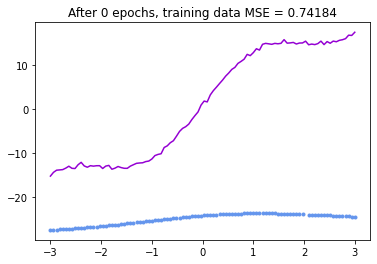

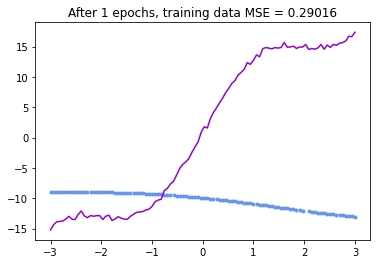

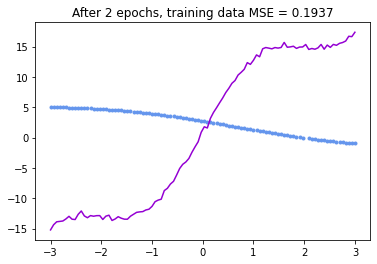

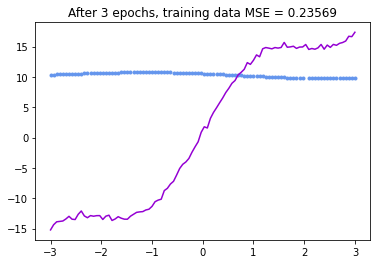

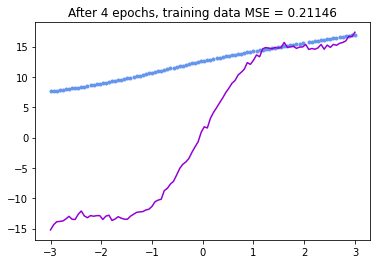

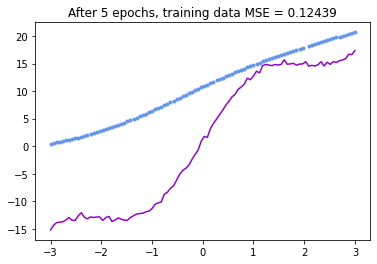

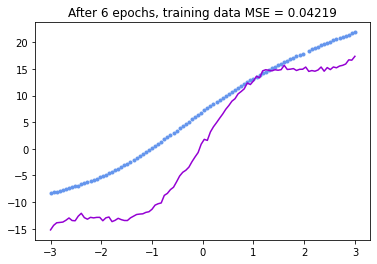

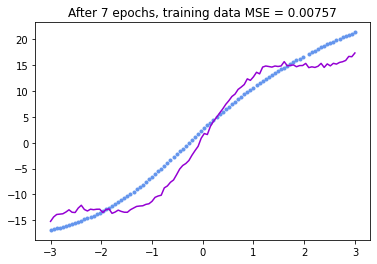

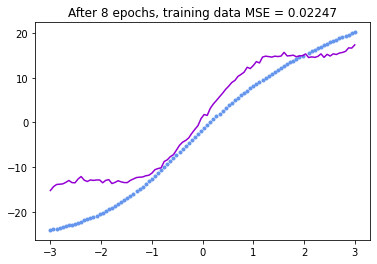

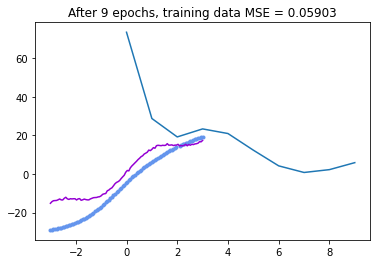

In [557]:
##Grad Descent Using Torch Optimiser
loss_graph = torch.empty(0)
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
start_time = time.perf_counter()
for epoch in range(10):
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x,requires_grad=False)
        b_y = Variable(batch_y)

        y_pred = net(b_x.float())     # input x and predict based on x
        
        loss =  loss_func(y_pred, b_y)     # must be (1. nn output, 2. target)
        loss_graph = torch.cat((loss_graph, loss.detach().flatten()),0) 
        print("epoch: ",epoch," loss: ",loss)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    ## print progress every x epochs  
    if(epoch%1==0):
        plt.figure()
        y_pred = scaler.inverse_transform(y_pred.detach().numpy())
        plt.plot(batch_x.numpy(), y_pred, linestyle='none', marker='.', color='cornflowerblue')
        plt.plot(x.numpy(), y2_original, linestyle='-', color='darkviolet')
        title = "After {} epochs, training data MSE = {}".format(epoch,(round(loss.detach().numpy()/len(batch_x.numpy()),5)))
        plt.title(title)
    if(loss<0.09):
        break
print("time taken to execute: ",time.perf_counter()-start_time)
plt.plot(loss_graph.numpy())    

In [560]:
## Levenberg Marquadt

# loss_graph = torch.empty(0)
# u=0.1 #beta multiply identity matrix
# b = 10
# V_prev = 0 #intialise performance index
# start_time = time.perf_counter()
# for epoch in range(EPOCH):
#     for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
#         b_x = Variable(batch_x,requires_grad=False)
#         b_y = batch_y.float()
#         y_pred = net(b_x)     # input x and predict based on x
#         num_param = inputs*firstLayer+firstLayer+firstLayer*output+output
#         jacobian = torch.empty(len(batch_x), num_param) 
#         e = (b_y-y_pred)
        
#         for n in range(len(batch_x)): #batch length is num of rows
#             net.zero_grad()
#             e[n].backward(retain_graph=True)
            
#             with torch.no_grad():
#                 param_grads = torch.empty(0) 

#                 for param in net.parameters():
#                     param_grads = torch.cat((param_grads, torch.flatten(param.grad).detach()),0) #puts gradient of params w.r.t e

#                 for m in range(num_param): #num params is num of coloumns
#                     jacobian[n][m] = param_grads[m]
        
#         #determine dParam
#     with torch.no_grad():
#         V_current = 0.5*torch.sum(torch.square(e.detach())) #performance index
#         if(V_current > V_prev):
#                 u *= b
#         else:
#                 u /= b
#         V_prev = V_current

#         dParam = torch.matmul(torch.matmul(torch.inverse(torch.matmul(torch.transpose(jacobian,-1,0),jacobian) + u*torch.eye(num_param, num_param)),torch.transpose(jacobian,-1,0)),e)

#         #update the params
#     c = 0
#     with torch.no_grad():    
#             for param in net.parameters():
#                 s = param.shape
#                 dParamUpdate = dParam[c:c+len(param.flatten())]
#                 c+= len(dParamUpdate)
#                 param -= 1*dParamUpdate.reshape(s)
#     loss =  loss_func(y_pred, b_y) 
#     loss_graph = torch.cat((loss_graph, loss.detach().flatten()),0) 
#     print("epoch: ",epoch,"loss: ",loss)    
#     ## print progress every x epochs
#     if(epoch%5==0):
#         plt.figure()
#         y_pred = scaler.inverse_transform(y_pred.detach().numpy())
#         plt.plot(batch_x.numpy(), y_pred, linestyle='none', marker='.', color='cornflowerblue')
#         plt.plot(x.numpy(), y2_original, linestyle='-', color='darkviolet')
#         title = "After {} epochs, training data MSE = {}".format(epoch,(round(loss.detach().numpy()/len(batch_x.numpy()),5)))
#         plt.title(title)
    
#     if(loss<0.01):
#         break
        
# print("time taken to execute: ",time.perf_counter()-start_time)   
# plt.plot(loss_graph.numpy()) 

MSE Mean:  89.86626
MSE STD Dev:  95.759636


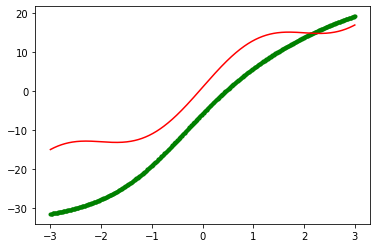

In [562]:
##check networks performance
def performanceCheck():
    x = torch.linspace(-3, 3, 500, requires_grad=False)
    x = x.reshape(len(x),1)

#     y2 = 0.5+torch.pow(x,3)
#     y2 = 1+torch.sin(0.5*np.pi*x+x)
#     y2 = 1+torch.sin(0.5*np.pi*x) +torch.pow(x,2)
    y2 = 1+5*torch.sin(0.5*np.pi*x) +7*x
    y_pred = net(x)
    y_pred = scaler.inverse_transform(y_pred.detach().numpy())
    plt.plot(x, y_pred,'g.',x, y2.numpy(),'r')
    MSE = (np.square(y_pred-y2.numpy()))
    print("MSE Mean: ",np.mean(MSE))
    print("MSE STD Dev: ",np.std(MSE))
performanceCheck()